In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem, zscore
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io
import glob

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
# fly_num = 'fly_240'
# func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
later_dir = '/oak/stanford/groups/trc/data/Ilana/2P/data/later/'


In [3]:
for x in sorted(os.listdir(later_dir)):
    if 'dic' in x:
        print(x)

fly_208_dic.pkl
fly_209_dic.pkl
fly_210_dic.pkl
fly_217_dic.pkl
fly_218_dic.pkl
fly_228_dic.pkl
fly_234_dic.pkl
fly_240_dic.pkl
total_dict.pkl


In [4]:
%%time
total_path = os.path.join(later_dir, 'total_dict.pkl')
if os.path.exists(total_path)==False:
    print("Making total dict")
    total_data_dict = {}

    for x in sorted(os.listdir(later_dir)):
        if 'dic' in x:
            fly_name= x[4:7]
            temp_path = os.path.join(later_dir, x)
            with open(temp_path, 'rb') as file:
                dic = pickle.load(file)
                total_data_dict[fly_name] = dic
    with open(total_path, 'wb') as file:
        pickle.dump(total_data_dict, file)
else:
    print("Loading total dict")
    with open(total_path, 'rb') as file:
        total_data_dict = pickle.load(file)

Loading total dict
CPU times: user 687 ms, sys: 9.86 s, total: 10.5 s
Wall time: 29.8 s


In [5]:
print(total_data_dict.keys())
print(total_data_dict['208'].keys())

dict_keys(['208', '209', '210', '217', '218', '228', '234', '240'])
dict_keys(['signals', 'timestamps', 'event_times', 'bins', 'behavior', 'cluster_labels'])


In [6]:
%%time
total_behave_struct = {}
shape = 196 #this is hard coded to be the smallest but i gotta figure this shit out better
for x in sorted(os.listdir(later_dir)):
    if 'dic' in x and 'total' not in x:
        fly_name= x[4:7]
        temp_path = os.path.join(later_dir, x)
        with open(temp_path, 'rb') as file:
            struct = pickle.load(file)
            total_behave_struct[fly_name] = struct['behavior'][:shape,:]
            temp = struct['behavior']

CPU times: user 708 ms, sys: 9.16 s, total: 9.87 s
Wall time: 38.3 s


In [7]:
print(total_behave_struct.keys())
print(total_behave_struct['208'])

dict_keys(['208', '209', '210', '217', '218', '228', '234', '240'])
[[-0.02049049 -0.09934544 -0.14182595 ...  0.89716809  0.64443755
   0.61008261]
 [ 2.19829244  2.21548318  2.30889055 ...  2.12225597  2.68696666
   2.91357651]
 [ 2.78844787  2.88711949  2.46983852 ... -0.11321083 -0.14129744
  -0.20726742]
 ...
 [-0.27897268 -0.10473932  0.06163674 ... -1.40347487 -1.56020656
  -1.83068043]
 [-0.56028323 -0.31940656 -0.39650352 ...  0.54944825  0.4654607
   0.3718529 ]
 [ 1.76361985  1.9054738   1.53088297 ...  3.22508106  3.08485663
   3.142519  ]]


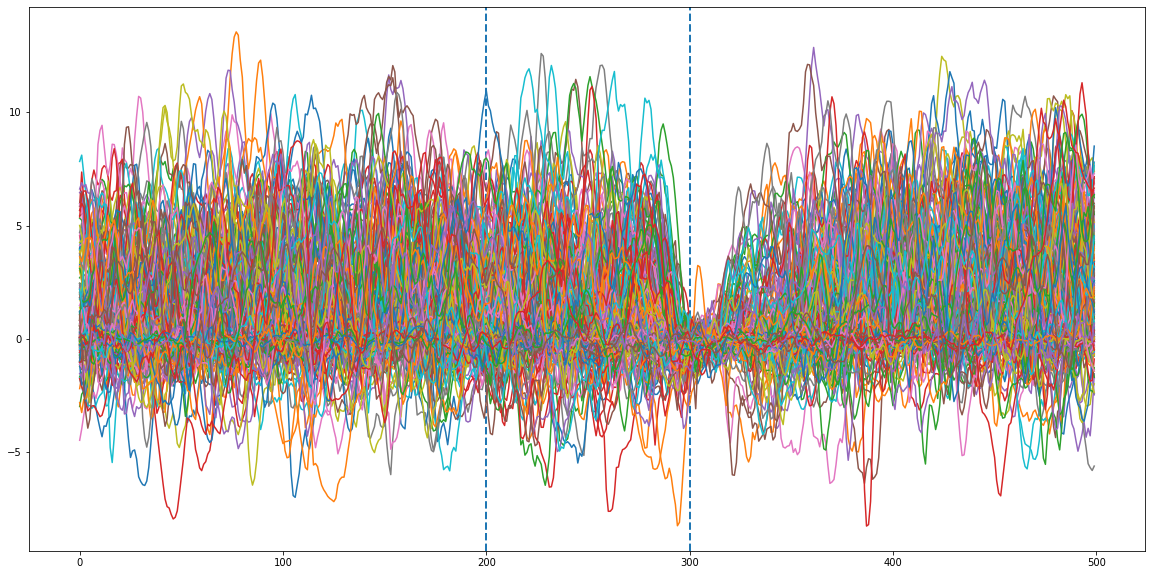

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
ax.axvline(200, linewidth=2, linestyle='--')
ax.axvline(300, linewidth=2, linestyle='--')
# for key in total_behave_struct:
plt.plot(total_behave_struct['240'].T);

In [9]:
def apply_boxcar_filter(arr):
    boxcar = np.ones(3) / 3  # Define the boxcar filter
    print(boxcar)
    filtered_arr = np.convolve(arr, boxcar, mode='same')  # Apply the filter
    return filtered_arr

[0.33333333 0.33333333 0.33333333]


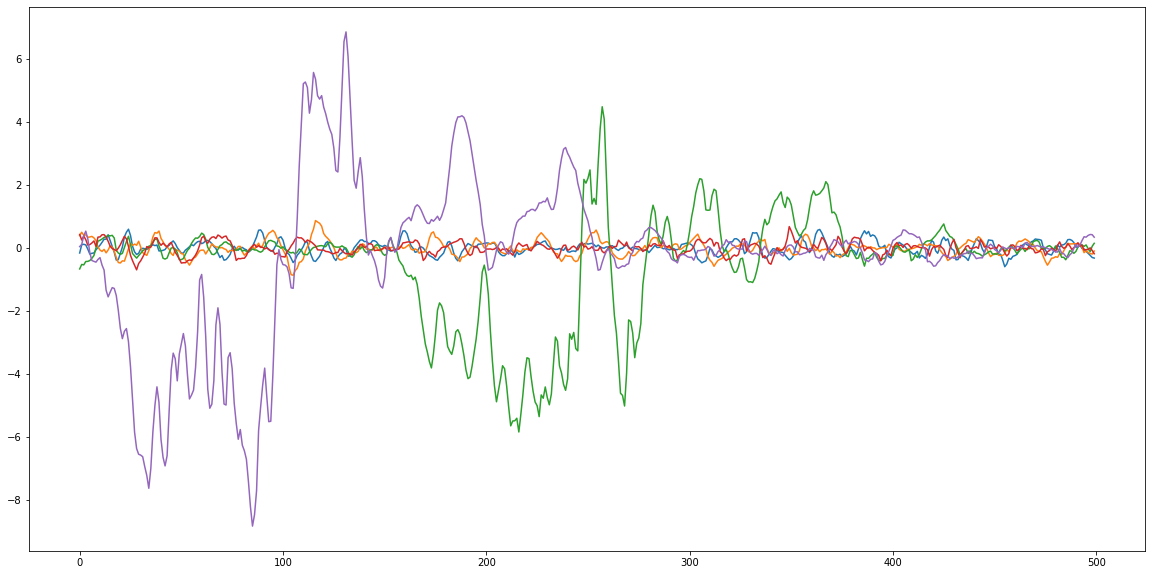

In [10]:
filterd = apply_boxcar_filter(total_behave_struct['240'][100,:])
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(total_behave_struct['234'][100:105,:].T);

In [11]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, method="gust")
    return y
def apply_butter_lowpass(behavior_traces, fr):
    # Filter requirements.
    order = 4
    fs = fr      # sample rate, Hz
    cutoff = 3  # desired cutoff frequency of the filter, Hz
    
    lpf_behavior = []
    
    for i in range(np.shape(behavior_traces)[0]):
        temp = butter_lowpass_filter(behavior_traces[i,:], cutoff, fs, order)
        lpf_behavior.append(temp)
    
    return np.asarray(lpf_behavior)

In [12]:
fr=100
lpf=apply_butter_lowpass(total_behave_struct['208'], fr)

(196, 500)


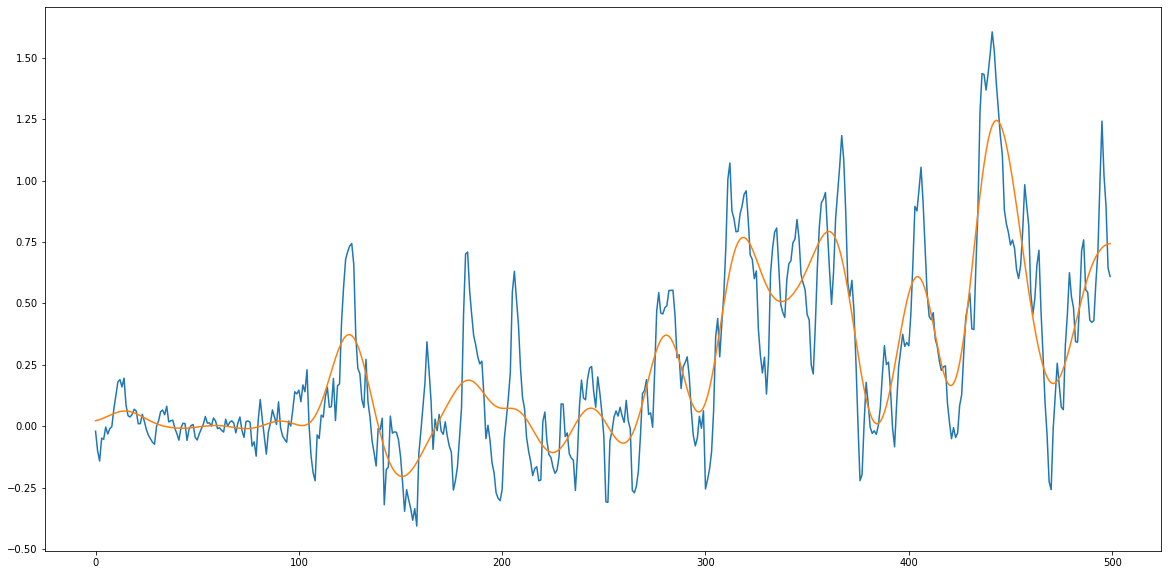

In [13]:
print(np.shape(lpf))
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(total_behave_struct['208'][0,:].T);
ax.plot(lpf[0,:].T);

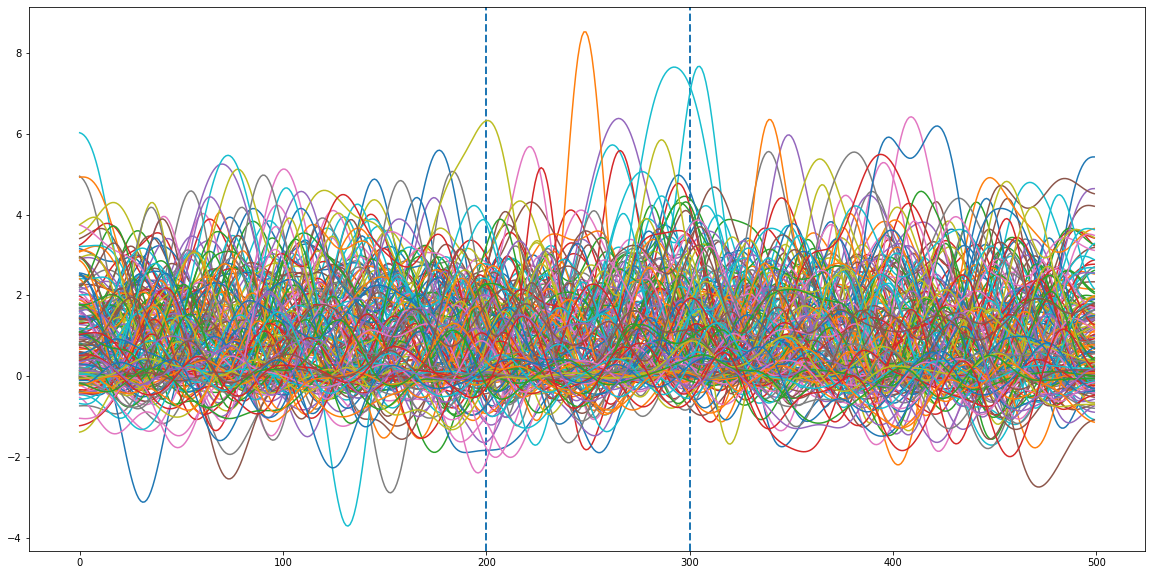

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax.axvline(200, linewidth=2, linestyle='--')
ax.axvline(300, linewidth=2, linestyle='--')
# for key in total_behave_struct:
plt.plot(lpf.T);

In [15]:
neg_trials = {}
count=0
for trial in total_behave_struct['208']:
    num_neg = np.count_nonzero(trial[:200]<-1)
    neg_trials[count]=num_neg
    count+=1

In [16]:
num=0
for key in neg_trials:
    if neg_trials[key]>=10:
        num+=1
print(num)

48


In [17]:
# fly = '209'
# thresh_val = 0.01

# weird_idx = np.where(np.count_nonzero(total_behave_struct[fly][:, :200]<-1, axis=1)>5)
# print(np.shape(weird_idx))
# greater = np.where(np.mean(total_behave_struct[fly][:, :200], axis=1)>thresh_val)
# # print(greater)
# print(np.shape(greater))
# less = np.where(np.mean(total_behave_struct[fly][:, :200], axis=1)<=thresh_val)
# print(np.shape(less))
# greater_s = np.asarray(list(set(greater[0])-set(weird_idx[0])))
# less_s = np.asarray(list(set(less[0])-set(weird_idx[0])))
# print(np.shape(greater_s))
# print(np.shape(less_s))

In [25]:
#get bin of trials where vel is less than -1 or something (neg trials, 0 trials, moving trials, weird trials)
thresh_val = 0.01
divided_behave = {"greater":{},"less":{}, "weird":{}}
gtotal = 0
ltotal = 0
wtotal = 0
for fly in total_behave_struct:
    weird = np.where(np.count_nonzero(total_behave_struct[fly][:, :200]<-1, axis=1)>10)
    divided_behave['weird'][fly] = total_behave_struct[fly][weird]
    wcount = np.shape(weird)[1]
    wtotal+=wcount
    print('Fly {} weird: {}'.format(fly, wcount))
    greater = np.where(np.mean(total_behave_struct[fly][:, :200], axis=1)>thresh_val)
    greater = np.asarray(list(set(greater[0])-set(weird[0])))
    divided_behave['greater'][fly] = total_behave_struct[fly][greater]
    gcount = np.shape(greater)[0]
    gtotal+=gcount
    print('Fly {} greater: {}'.format(fly, gcount))
    less = np.where(np.mean(total_behave_struct[fly][:, :200], axis=1)<=thresh_val)
    less = np.asarray(list(set(less[0])-set(weird[0])))
    divided_behave['less'][fly] = total_behave_struct[fly][less]
    lcount = np.shape(less)[0]
    ltotal+=lcount
    print('Fly {} less: {}'.format(fly, lcount))
print('Greater total: {}'.format(gtotal))
print('Less total: {}'.format(ltotal))
print('Weird total: {}'.format(wtotal))

Fly 208 weird: 45
Fly 208 greater: 140
Fly 208 less: 11
Fly 209 weird: 46
Fly 209 greater: 73
Fly 209 less: 77
Fly 210 weird: 27
Fly 210 greater: 63
Fly 210 less: 106
Fly 217 weird: 56
Fly 217 greater: 82
Fly 217 less: 58
Fly 218 weird: 42
Fly 218 greater: 93
Fly 218 less: 61
Fly 228 weird: 98
Fly 228 greater: 75
Fly 228 less: 23
Fly 234 weird: 70
Fly 234 greater: 83
Fly 234 less: 43
Fly 240 weird: 96
Fly 240 greater: 94
Fly 240 less: 6
Greater total: 703
Less total: 385
Weird total: 480


In [41]:
gtot = 0
for fly in total_behave_struct:
    g = np.where(np.mean(total_behave_struct[fly][:, 190:200], axis=1)>=3)
    gc = np.shape(g)[1]
#     gc = np.shape(g)[0]
    gtot+=gc
    print('Fly {} greater or equal to 3mm/sec: {}'.format(fly, gc))
print('Greater total: {}'.format(gtot))

Fly 208 greater or equal to 3mm/sec: 8
Fly 209 greater or equal to 3mm/sec: 4
Fly 210 greater or equal to 3mm/sec: 4
Fly 217 greater or equal to 3mm/sec: 1
Fly 218 greater or equal to 3mm/sec: 3
Fly 228 greater or equal to 3mm/sec: 7
Fly 234 greater or equal to 3mm/sec: 11
Fly 240 greater or equal to 3mm/sec: 41
Greater total: 79


In [32]:
def plot_flies(struct):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.axvline(200, linewidth=2, linestyle='--')
    ax.axvline(300, linewidth=2, linestyle='--')
    for key in struct:
        f=np.mean(struct[key], axis=0)
    #     print(np.shape(f))
        ax.plot(f.T, label=key)
        ax.legend()
    # # ax.plot(np.mean(total_behave, axis=1).T)

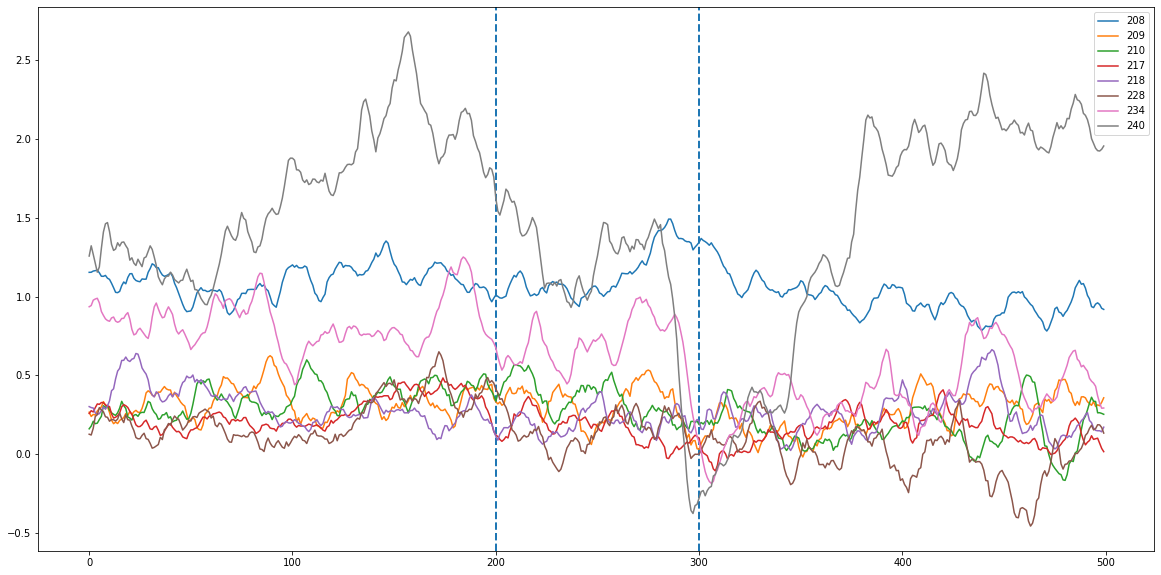

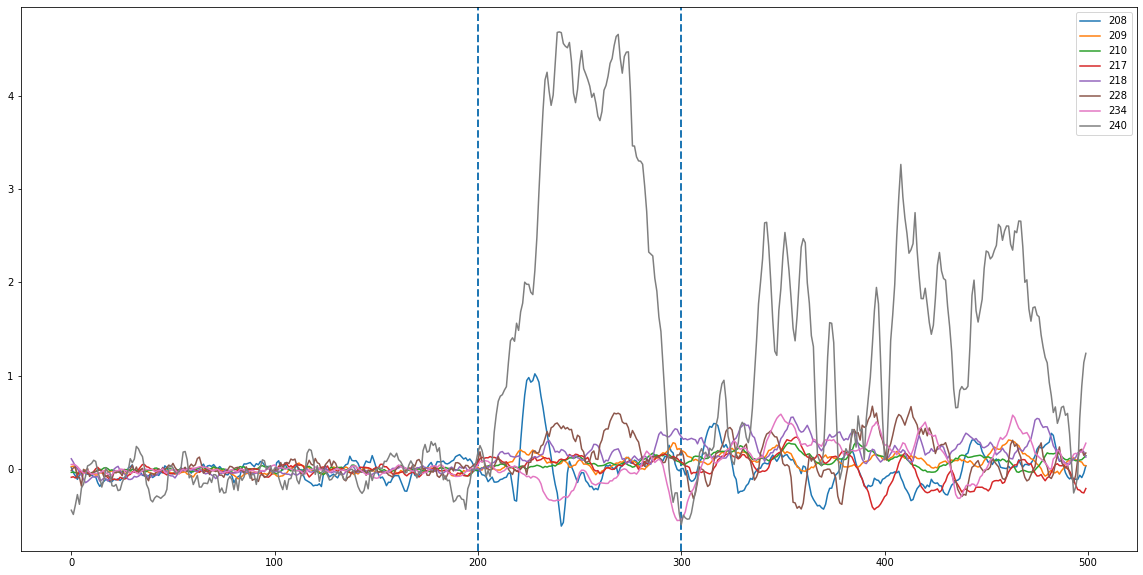

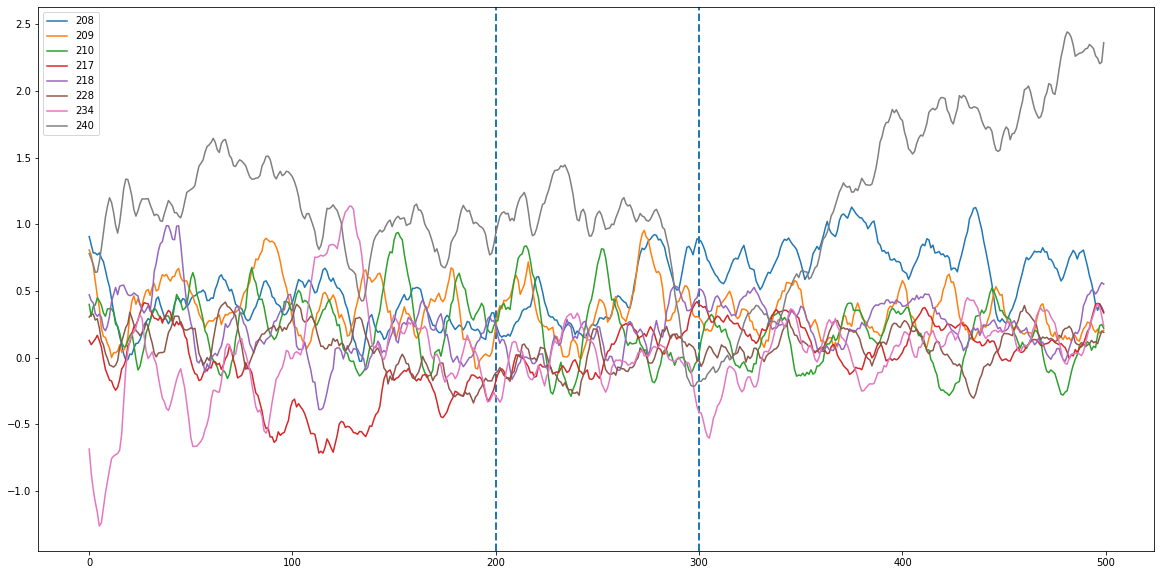

In [33]:
plot_flies(divided_behave['greater'])
plot_flies(divided_behave['less'])
plot_flies(divided_behave['weird'])

In [ ]:
def norm_behave(struct, norm=None):
    norm_struct = {}
    for fly in struct:
        temp = struct[fly]
        pre_v = temp[:,100:200]
        mean_pre = np.mean(pre_v)
        std_pre = np.std(pre_v)
        if norm=='zscore':
            temp_norm = (temp-mean_pre)/std_pre
        elif norm=='meanscore':
            temp_norm = (temp-mean_pre)/mean_pre
        elif norm=='clark':
            temp_norm = temp/mean_pre
        elif norm=='scipy':
            temp_norm = zscore(temp, axis=1)
        else:
            print("No established norm type. Try again. Options: zscore, meanscore, clark, scipy.")
        try:
            norm_struct[fly]=temp_norm
        except:
            break
    return norm_struct
        

In [ ]:
plot_flies(norm_behave(divided_behave['greater'], norm='clark'))
# plot_flies(norm_behave(divided_behave['greater'], norm='meanscore'))
plot_flies(norm_behave(divided_behave['greater'], norm='zscore'))

In [ ]:
zs=norm_behave(total_behave_struct, norm='zscore')
meanscore=norm_behave(total_behave_struct, norm='meanscore')
social=norm_behave(total_behave_struct, norm='clark')
sp=norm_behave(total_behave_struct, norm='scipy')
gsocial=norm_behave(divided_behave['greater'], norm='clark')
er_test=norm_behave(total_behave_struct, norm=None)


In [ ]:
fly = "208"

a=np.mean(total_data_dict[fly]['behavior'], axis=0)
# print(np.shape(a))
b=np.mean(zs[fly], axis=0)
# print(np.shape(b))
c=np.mean(meanscore[fly], axis=0)
d=np.mean(social[fly], axis=0)
e=np.mean(sp[fly], axis=0)
f=np.mean(divided_behave['greater'][fly], axis=0)
g=np.mean(gsocial[fly], axis=0)
fig, ax = plt.subplots(figsize=(20,10))
# fig.subplots(figsize=(10,10))
ax.plot(a.T, label='No normalization')
ax.plot(b.T, label='z-score')
ax.plot(c.T, label='mean-score')
ax.plot(d.T, label='social behavior')
ax.plot(e.T, label='scipy')
ax.plot(f.T, label='greater')
ax.plot(g.T, label='greater social')
ax.legend()

In [ ]:
plot_flies(total_behave_struct)
plot_flies(social)
plot_flies(gsocial)

In [ ]:
def plot_trace(behavior_trace, pre_window, post_window, stim_time, ax=None, fig=None):
    mean_trace = np.mean(behavior_trace, axis=0)
    sem_trace = scipy.stats.sem(behavior_trace, axis=0)
    color='b'
    
    if ax==None:
        fig, ax = plt.subplots(figsize=(10,10))
        color='k'
#     plt.figure(figsize=(10,10))
    ax.plot(mean_trace,color=color,linewidth=3)
    ax.fill_between(np.arange(np.shape(mean_trace)[0]),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
    ax.axvline(pre_window,color='k',linestyle='--',lw=2)
    ax.axvline(pre_window+stim_time,color='k',linestyle='--',lw=2)
#     ax.set_ylim(-0.5, 3.5);
    return fig, ax

In [ ]:
def overall_behavior_array(struct):
    temp = []
    for key in struct:
        try:
            lst = struct[key]['traces']
        except IndexError:
            lst = struct[key]
#         print(np.shape(lst))
        temp.append(lst)
    temp = np.vstack(temp)
#     print(np.shape(temp))
#     temp = np.mean(temp, axis=0)
    return np.asarray(temp)

In [ ]:
total = overall_behavior_array(total_behave_struct)
total_norm = overall_behavior_array(social)

total1 = overall_behavior_array(divided_behave['greater'])
total_norm1 = overall_behavior_array(gsocial)

In [ ]:
pre_window = 200
post_window = 300
stim_time = 100
fig, ax = plot_trace(total, pre_window, post_window, stim_time)
plot_trace(total_norm, pre_window, post_window, stim_time, ax=ax)

fig1, ax1 = plot_trace(total1, pre_window, post_window, stim_time)
plot_trace(total_norm1, pre_window, post_window, stim_time, ax=ax1)

In [ ]:
value_struct ={
    # the data is in 10ms, use this value to get the index if i use seconds
    "tp_width_sec": 0.01,
    "trial_time_sec": 1,
    "before_stim_sec": pre_window/100,
    # time in seconds between end of pre trial window and the stimulus time. 
    # when set to zero, the pre trial window ends when the stimulus is presented
    "pre_trial_window_sec": 0.01,
    # size of window that pre trial speed is averaged over, seconds, window ends at stimulus time
    # when 0 is a single val and not a window
    "pre_trial_size_sec": 0.5,
    # size of post trial speed average window, sec
    "post_trial_window_sec": 0.5,
    # post trial window at stim tiem + post trail delay
    # when 0 is a single val and not a window
    "post_trial_size_sec": 0.5,
    "thresh": 0.05,
    "fr": 100.00033694743087 
    #frame rate
    }

In [ ]:
#normalized
inc_n_dict, dec_n_dict, flat_n_dict = brainsss.separate_traces(social, value_struct)
#only moving trials
inc_dict, dec_dict, flat_dict = brainsss.separate_traces(gsocial, value_struct)
#total
inct, dect, flatt = brainsss.separate_traces(total_behave_struct, value_struct)

In [ ]:
def plotable_arrays(inc, dec, flat):
    inc_lst = overall_behavior_array(inc)
    dec_lst = overall_behavior_array(dec)
    flat_lst = overall_behavior_array(flat)
    return inc_lst, dec_lst, flat_lst

In [ ]:
inc_n, dec_n, flat_n = plotable_arrays(inc_n_dict, dec_n_dict, flat_n_dict)
inc, dec, flat = plotable_arrays(inc_dict, dec_dict, flat_dict)

In [ ]:
fig1,ax1 = plot_trace(dec, pre_window, post_window, stim_time)
plot_trace(dec_n, pre_window, post_window, stim_time, ax=ax1)
# print(np.shape(dec_n))
fig2,ax2 = plot_trace(inc, pre_window, post_window, stim_time)
plot_trace(inc_n, pre_window, post_window, stim_time, ax=ax2)
# print(np.shape(inc_n))
fig3,ax3 = plot_trace(flat, pre_window, post_window, stim_time)
plot_trace(flat_n, pre_window, post_window, stim_time, ax=ax3)
# print(np.shape(flat_n))

In [ ]:
def get_event_times_list(trials, event_times, ms=True):
    trials_idx = np.where(trials)
    trials_starts =[]
    for idx in trials_idx[0]:
        trials_starts.append(event_times[idx])
    if ms==True:
        trials_starts = [n*10 for n in trials_starts]
    print(np.shape(trials_starts))
    return trials_starts

In [ ]:
total_data_dict['208'].keys()

In [ ]:
print(inc_dict['208'].keys())
dec_n_dict.keys() 
flat_n_dict.keys()

In [ ]:
def get_event_times_dict(total_data_dict, ms=True, total=False, traces=None):
    event_starts={}
    starts_size=0

    for key in total_data_dict:
        if total==False:
            event_times = total_data_dict[key]['event_times']
            idx = traces[key]['idx'][0]
            event_times = [event_times[i] for i in idx]
            starts_size+=np.size(event_times)
            if ms==True:
                event_times =  [n*10 for n in event_times]
        elif total==True:
            event_times=total_data_dict[key]['event_times'][:196]#this is shittily hardcoded but rn it's the smallest number of trials
            starts_size+=np.size(event_times)
            if ms==True:
                event_times =  [n*10 for n in event_times]
        event_starts[key] = event_times
    print(starts_size)
    return event_starts


In [ ]:
decrease_starts_ms = get_event_times_dict(total_data_dict, ms=False, total=False, traces=dect)
increase_starts_ms = get_event_times_dict(total_data_dict, ms=False, total=False, traces=inct)
flat_starts_ms = get_event_times_dict(total_data_dict, ms=False, total=False, traces=flatt)
total_starts_ms = get_event_times_dict(total_data_dict, ms=False, total=True, traces=True)


In [ ]:
def dic_shape(dic):
    sx=len(dic)
    sy=0
    for key in dic:
        temp = len(dic[key])
        print('{} is {}'.format(key,temp))
        sy+=temp
    return sx,sy

In [ ]:
x,dy = dic_shape(increase_starts_ms)
print(x,dy)

In [ ]:
%%time
STA_brains={}
for key in total_data_dict:
    STA_brains[key]={}
    STA_brain_decrease = brainsss.make_STA_brain(neural_signals = total_data_dict[key]['signals'],
                                       neural_timestamps = total_data_dict[key]['timestamps'],
                                       event_times_list = decrease_starts_ms[key],
                                       neural_bins = total_data_dict[key]['bins'])
#     print(STA_brain_decrease)
    STA_brains[key]['decrease']=STA_brain_decrease

    STA_brain_increase = brainsss.make_STA_brain(neural_signals = total_data_dict[key]['signals'],
                                       neural_timestamps = total_data_dict[key]['timestamps'],
                                       event_times_list = increase_starts_ms[key],
                                       neural_bins = total_data_dict[key]['bins'])
    STA_brains[key]['increase']=STA_brain_increase

    STA_brain_flat = brainsss.make_STA_brain(neural_signals = total_data_dict[key]['signals'],
                                       neural_timestamps = total_data_dict[key]['timestamps'],
                                       event_times_list = flat_starts_ms[key],
                                       neural_bins = total_data_dict[key]['bins'])
    STA_brains[key]['flat']=STA_brain_flat

    STA_brain = brainsss.make_STA_brain(neural_signals = total_data_dict[key]['signals'],
                                       neural_timestamps = total_data_dict[key]['timestamps'],
                                       event_times_list = total_starts_ms[key],
                                       neural_bins = total_data_dict[key]['bins'])
    STA_brains[key]['total']=STA_brain
    

In [ ]:
STA_brains.keys()

In [ ]:
STA_brains['208'].keys()

In [ ]:
%%time
for key in STA_brains:
    for d in STA_brains[key]:
        no_nan = np.nan_to_num(STA_brains[key][d])
        reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(no_nan, total_data_dict[key]['cluster_labels'])
        STA_brains[key][d] = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)

In [ ]:
fixed = brainsss.load_fda_meanbrain()

In [ ]:
atlas = brainsss.load_roi_atlas()

In [ ]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [ ]:
def warp_STA_brain(STA_brain, fly, fixed, anat_to_mean_type, func_path):
    n_tp = STA_brain.shape[1]
    moving_resolution = (2.611, 2.611, 5)
    ###########################
    ### Organize Transforms ###
    ###########################
    warp_directory = os.path.join(func_path,'warp')
    warp_sub_dir = 'func-to-anat_fwdtransforms_2umiso'
    affine_file = os.listdir(os.path.join(warp_directory, warp_sub_dir))[0]
    affine_path = os.path.join(warp_directory, warp_sub_dir, affine_file)
    if anat_to_mean_type == 'myr':
        warp_sub_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'
    elif anat_to_mean_type == 'non_myr':
        warp_sub_dir = 'anat-to-non_myr_mean_fwdtransforms_2umiso'
    else:
        print('invalid anat_to_mean_type')
        return
    syn_files = os.listdir(os.path.join(warp_directory, warp_sub_dir))
    syn_linear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.mat' in x][0])
    syn_nonlinear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.nii.gz' in x][0])
    ####transforms = [affine_path, syn_linear_path, syn_nonlinear_path]
    transforms = [syn_nonlinear_path, syn_linear_path, affine_path] ### INVERTED ORDER ON 20220503!!!!
    #ANTS DOCS ARE SHIT. THIS IS PROBABLY CORRECT, AT LEAST IT NOW WORKS FOR THE FLY(134) THAT WAS FAILING


    ### Warp timeponts
    warps = []
    for tp in range(n_tp):
        to_warp = np.rollaxis(STA_brain[:,tp,:,:],0,3)
        moving = ants.from_numpy(to_warp)
        moving.set_spacing(moving_resolution)
        ########################
        ### Apply Transforms ###
        ########################
        moco = ants.apply_transforms(fixed, moving, transforms)
        warped = moco.numpy()
        warps.append(warped)

    return warps

In [ ]:
%%time
warp_path = os.path.join(later_dir, 'total_warps.pkl')
# if os.path.exists(warp_path)==False:
print("Making total warps")
total_warps = {}

for key in STA_brains:
    total_warps[key]={}
    for d in STA_brains[key]:
        fly_name = 'fly_{}'.format(key)
        path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_name}/'
        warps = warp_STA_brain(STA_brain=STA_brains[key][d], fly=key, fixed=fixed, anat_to_mean_type='myr', func_path=path)
#             print(warps)
        total_warps[key][d] = warps
with open(warp_path, 'wb') as file:
    pickle.dump(total_warps, file)
# else:
#     print("Loading total warps")
#     with open(warp_path, 'rb') as file:
#         total_warps = pickle.load(file)

In [ ]:
total_warps['208'].keys()

In [ ]:
dec_warps = []
inc_warps = []
flat_warps = []
total = []

for fly in total_warps:
    for key in total_warps[fly]:
        if key=='decrease':
#             print(np.shape(total_warps[fly][key]))
            dec_warps.append(total_warps[fly][key])
        elif key=='increase':
#             print(np.shape(total_warps[fly][key]))
            inc_warps.append(total_warps[fly][key])
        elif key=='flat':
#             print(np.shape(total_warps[fly][key]))
            flat_warps.append(total_warps[fly][key])
        else: 
#             print(np.shape(total_warps[fly][key]))
            total.append(total_warps[fly][key])
dec_warp_mean = np.asarray(np.mean(dec_warps, axis=0))
inc_warp_mean = np.asarray(np.mean(inc_warps, axis=0))
flat_warp_mean = np.asarray(np.mean(flat_warps, axis=0))
total_warp_mean = np.asarray(np.mean(total, axis=0))

In [ ]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [ ]:
#################
###CHANGE THIS###
#################
warps = total_warp_mean

In [ ]:
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[tp][:,:,::-1]
    vmax = 0.5 #this was 0.5 for STA <------------
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')

In [ ]:
movie_dir = os.path.join(later_dir, 'movies')
if os.path.exists(movie_dir)==False:
    os.mkdir(movie_dir)
print(movie_dir)

In [ ]:
save_dir = os.path.join(movie_dir,'total')
if os.path.exists(save_dir)==False:
    os.mkdir(save_dir)
print(save_dir)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(24):
    print(i)
    plt.imshow(explosions[i][170:,:]) #this was made with cmap=hot
    fname = os.path.join(save_dir, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=300,bbox_inches='tight')